<a href="https://colab.research.google.com/github/RonTeichner/IRAS/blob/main/IRAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identifying Regulation with Adversarial Surrogate**

An example of evaluating IRAS algorithm from the paper `Identifying Regulation with Adversarial Surrogate'.


In the following example IRAS algorithm is evaluated over time-series observations obtained from the Lotka-Volterra dynamical system,
$$
\begin{equation}
\begin{split}
\dot{x} &= \alpha x - \beta x y\\
\dot{y} &= \delta x y - \gamma y.
\end{split}
\end{equation}
$$
The obtained observations $z(t)$ are the numbers of predator and prey corrupted by additive white noise $n(t) \in \mathbb{R}^2$,
$$
\begin{equation}
z(t) \overset{\Delta}{=} \begin{bmatrix} z_1(t) \\ z_2(t)\end{bmatrix} = \begin{bmatrix}x(t) \\ y(t)\end{bmatrix} + n(t).
\end{equation}
$$

The Lotka-Volterra model has an conserved quantity,
$$
\begin{equation}
{\cal{V}}(x,y) = \delta x - \gamma \log(x) + \beta y - \alpha \log(y)
\end{equation}
$$
which should be correctly identified by IRAS, yielding the learned combination,
$$
\begin{equation}
g(z) = \delta z_1 - \gamma \log(z_1) + \beta z_2 - \alpha \log(z_2).
\end{equation}
$$

In what follows we


1.   Create a dataset of $M$ time-series observations ${\cal{D}}=\{z^{(s)}(t)\}_{s=0}^{M-1}$
2.   Run the IRAS algorithm over ${\cal{D}}$
3.   Examine the Pearson correlation between ${\cal{V}}(x,y)$ and the learned combination $g(z)$. A high correlation testifies that the conserved quantity ${\cal{V}}$ was successfully learned.
4.   While training, we examine the the learned combination $g(z)$, learned by the combination player via a heat-map over the phase space $(z_1,z_2)$. In addition, we examine the resampling function $\zeta(\cdot)$ learned by the shuffle player and used to generate the constrained shuffle ensemble $\tilde{z}$. 

## Generating observations from the Lotka-Volterra model
In the following code we create observations for 20 time-series from the Lotka-Volterra model with parameters, $(\alpha,\beta,\gamma,\delta)=(0.2, 0.025, 0.1, 0.02)$ and initial conditions $x_0 \sim U[4,5]$, $y_0 \sim U[7,8]$. The models are integrated from $t=0$ to $t=500$ using *solve_ivp* from *scipy* to obtain $x(t)$ and $y(t)$. Then, $z(t)$ is a noissy observation of $x,y$.



In [1]:
from scipy.integrate import solve_ivp
import numpy as np

def lotkavolterra(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

def lotkavolterra_jac(t, z, a, b, c, d):
    x, y = z
    return np.array([[a-b*y, -b*x], [d*y, -c+d*x]])

def createSys(T, lotkavolterra, lotkavolterra_jac, SNR, factor):
    simTimes = [0, T]
    rtol = 1e-12
    method = 'Radau'
    fs = 1
    isnan = True
    while isnan:
        params = (0.2, 0.025, 0.1, 0.02)        
        a,b,c,d = params
        factor = 0
        x0, y0 = 4 + factor*np.random.rand(), 7 + factor*np.random.rand()
       
        sol = solve_ivp(lotkavolterra, simTimes, [x0, y0], args=params, dense_output=True, method=method, jac=lotkavolterra_jac, rtol=rtol)
        t = np.linspace(0, T, int(fs*T))
        z = sol.sol(t)
        
        noiseStd = np.sqrt(np.power(z,2).mean()/SNR)
        noise = noiseStd*np.random.randn(z.shape[1])
        
        dot_z = np.asarray(lotkavolterra(0, z, a, b, c, d))
        unitParallelVec = np.divide(dot_z, np.linalg.norm(dot_z, axis=0)[None,:].repeat(2,0))
        unitOrthogonalVec = np.zeros_like(unitParallelVec)
        unitOrthogonalVec[0] = -unitParallelVec[1]
        unitOrthogonalVec[1] = unitParallelVec[0]        
        unitOrthogonalVec = np.divide(unitOrthogonalVec, np.linalg.norm(unitOrthogonalVec, axis=0)[None,:].repeat(2,0))
        OrthogonalNoise = unitOrthogonalVec*noise[None, :].repeat(2,0)
        OrthogonalNoise = OrthogonalNoise * (np.random.randint(low=0, high=2, size=unitOrthogonalVec.shape[1])*2-1)[ None,:].repeat(2,0)
        
        z = z + OrthogonalNoise        
        x, y = z.T[:,0], z.T[:,1]
        V = d*x - c*np.log(x) + b*y - a*np.log(y)
        if not(np.isnan(V).any()):
            isnan = False
    return (a,b,c,d, t, z, V)

factor = 0.01
nSys = 64
T = 500 # [sec]
springSysList = list()
for i in range(nSys):    
    springSysList.append(createSys(T, lotkavolterra,lotkavolterra_jac, SNR=10000, factor=factor))

tVec = springSysList[0][4]
nSamples = tVec.shape[0]
observations = np.zeros((nSys, nSamples, 2))
V = np.zeros((nSys, nSamples))
for s in range(len(springSysList)):
    observations[s,:,0] = springSysList[s][5][0]
    observations[s,:,1] = springSysList[s][5][1]
    V[s,:] = springSysList[s][6]

Now we can print the trajectory and $(x,y)$ phase space for one observed system,

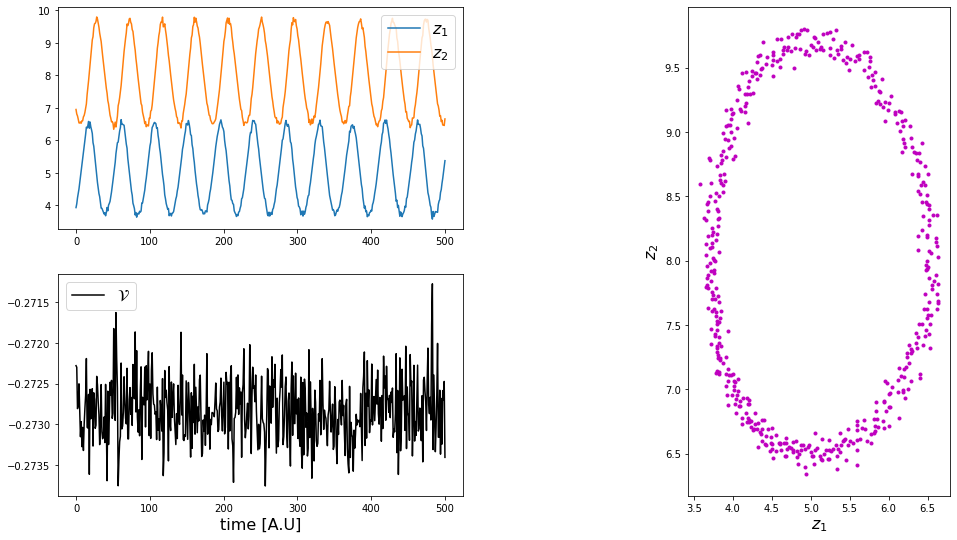

In [2]:
import matplotlib.pyplot as plt

systemIdx = 0
z1 = observations[systemIdx,:,0]
z2 = observations[systemIdx,:,1]
v = V[systemIdx]

plt.figure(figsize=(16,9))
fontsize=16
plt.subplot(2,2,1)
plt.plot(tVec,z1,label=r'$z_1$')
plt.plot(tVec,z2,label=r'$z_2$')
plt.legend(fontsize=fontsize)
plt.subplot(2,2,3)
plt.plot(tVec,v,'k',label=r'${\cal{V}}$')
plt.legend(fontsize=fontsize)
plt.xlabel('time [A.U]',fontsize=fontsize)
plt.subplot(1,3,3)
plt.plot(z1,z2,'m.')
plt.xlabel(r'$z_1$',fontsize=fontsize)
plt.ylabel(r'$z_2$',fontsize=fontsize)
plt.show()


# saving some statistics for future normalization
import pandas as pd
featureMean, featureStd = list(), list()
for f in range(observations.shape[2]):  
  featureValues = observations[:, :, f].flatten()
  featureValues_05, featureValues_95 = pd.Series(featureValues).quantile(0.05), pd.Series(featureValues).quantile(0.95)
  featureMean.append(featureValues[np.logical_and(featureValues >= featureValues_05, featureValues <= featureValues_95)].mean())
  featureStd.append(featureValues[np.logical_and(featureValues >= featureValues_05, featureValues <= featureValues_95)].std())

mu = np.asarray(featureMean)[:, None]
stdsVec = np.asarray(featureStd)[:, None]
stdsVec[stdsVec == 0] = 1

Sigma_minus_half = np.diag(1/stdsVec[:,0])
Sigma_half = np.diag(stdsVec[:,0])

import torch
observations = torch.from_numpy(observations).type(torch.float)
Vtorch = torch.from_numpy(V).type(torch.float)

## Define the neural-network $g(z)$ (combination player), the shuffle player and the Coefficient of Regulation loss
Next we define


1.   The combination player as a neural-network $g: \mathbb{R}^2 → \mathbb{R}$ that will output a combination $c = g(z)$ for each observation $z$.
2.   The shuffle player that assigns each element in the naive-shuffled ensemble $z^*$ the probability of including it in the constrained-shuffled ensemble $\tilde{z}$. The shuffle player assigns the probability via the resampling function $\zeta(\cdot)$ such that it minimizes the objective,
$$
\begin{equation}
\begin{split}
&min_{\zeta} D(P_z(g(z),P_{\tilde{z}}(g(\tilde{z})))\\
&\text{s.t } \tilde{z} \sim P_{\tilde{z}}(g(\tilde{z}))=P_{z^*}(g(\tilde{z}))\zeta(g(\tilde{z}))
\end{split}
\end{equation}
$$
3.   The minimization objective of the combination player which is the Coefficient of Regulation with respect to the constrained shuffled ensemble,
$$
\begin{equation}
  min_g\frac{\sigma\left(c \sim P_z(g(z))\right)}{\sigma\left(\tilde{c} \sim P_{\tilde{z}}(g(\tilde{z})))\right)}.
\end{equation}
$$





In [8]:
import torch
import torch.nn as nn


class Combination_ANN(nn.Module):
  def __init__(self, mu, Sigma_minus_half):
        super(Combination_ANN, self).__init__()
        self.inputDim = 2
        self.shuffleFactor = 100
        self.Sigma_minus_half = nn.parameter.Parameter(torch.tensor(Sigma_minus_half, dtype=torch.float), requires_grad=False)
        self.mu = nn.parameter.Parameter(torch.tensor(mu, dtype=torch.float), requires_grad=False)

        self.sequence = nn.Sequential(nn.Linear(self.inputDim, 32),
                                                  nn.LeakyReLU(),                                                  
                                                  nn.Linear(32, 16),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(16, 1),
                                                  nn.Tanh())
  def shuffle(self, observations):
    naiveShuffledObservations = torch.zeros_like(observations)
    for s in range(observations.shape[0]):
      for f in range(observations.shape[2]):
        permuteIdx = torch.randperm(observations.shape[1])
        naiveShuffledObservations[s,:,f] = observations[s,permuteIdx,f]
    return naiveShuffledObservations

  def multipleShuffles(self, observations):
    naiveShuffledObservations = torch.zeros((observations.shape[0], int(observations.shape[1]*self.shuffleFactor), observations.shape[2]), dtype=torch.float, device=observations.device)     
    for sf in range(self.shuffleFactor):
      naiveShuffledObservations[:,sf*observations.shape[1]:(sf+1)*observations.shape[1]] = self.shuffle(observations)
    return naiveShuffledObservations

  def normalizeObservations(self, observations):
    nSystem = observations.shape[0]
    nTime = observations.shape[1]
    means = self.mu[None, None, :, :].expand(nSystem, nTime, -1, -1)
    Sigma_minus_half = self.Sigma_minus_half[None, None, :, :].expand(nSystem, nTime, -1, -1)
    tilde_z = observations[:, :, :, None]
    nan_indices = tilde_z.isnan()
    tilde_z[nan_indices] = torch.zeros_like(tilde_z[nan_indices])
    normalized_tilde_z = torch.matmul(Sigma_minus_half, tilde_z - means)
    normalized_tilde_z[nan_indices] = torch.nan
    normalized_tilde_z = normalized_tilde_z[:,:,:, 0]   
    
    return normalized_tilde_z
  
  def forward(self, observations):    
    naiveShuffledObservations = self.multipleShuffles(observations)       
    combination = self.sequence(self.normalizeObservations(observations))
    combinationOnNaiveShuffle = self.sequence(self.normalizeObservations(naiveShuffledObservations))
    return combination, combinationOnNaiveShuffle, naiveShuffledObservations

def move_to(obj, device):
  if torch.is_tensor(obj):
    return obj.to(device)
  elif isinstance(obj, dict):
    res = {}
    for k, v in obj.items():
      res[k] = move_to(v, device)
    return res
  elif isinstance(obj, list):
    res = []
    for v in obj:
      res.append(move_to(v, device))
    return res
  else:
    raise TypeError("Invalid type for move_to") 

def shufflePlayer(combination, combinationOnNaiveShuffle):
  device = combination.device
  combination, combinationOnNaiveShuffle = combination.detach(), combinationOnNaiveShuffle.detach()
  nBins = 50
  shuffleFactor = int(combinationOnNaiveShuffle.shape[1]/combination.shape[1])
  baseLength = combination.shape[1]
  nSystems = combination.shape[0]

  binsDict, prob_data, prob_shuffle = list(), list(), list()
  for p in range(nSystems):            
    comb_data_flatten_singleSystem = combination[p, :, 0]            
    
    systemShuffledCombinationProbIndices = (torch.arange(baseLength, dtype=torch.long, device=combination.device)[:, None].repeat(1, shuffleFactor) + baseLength*torch.arange(shuffleFactor, dtype=torch.long, device=combination.device)[None, :].repeat(baseLength, 1)).flatten()
    comb_shuffle_flatten_singleSystem = torch.gather(combinationOnNaiveShuffle[p,:,0], 0, systemShuffledCombinationProbIndices)                                    
    
    min_range = comb_data_flatten_singleSystem.min()
    max_range = comb_data_flatten_singleSystem.max()
    
    bins = torch.linspace(min_range, max_range, nBins, device='cpu')
    prob_data_patient = torch.histogram(comb_data_flatten_singleSystem.to('cpu'), bins=bins.to('cpu'), density=True)[0]
    prob_shuffle_patient = torch.histogram(comb_shuffle_flatten_singleSystem.to('cpu'), bins=bins.to('cpu'), density=True)[0]

    if prob_data_patient.isnan().any():
      prob_data.append(torch.ones_like(bins[:-1].to('cpu')) / bins[:-1].shape[0])
    else:
      prob_data.append(prob_data_patient)

    if prob_shuffle_patient.isnan().any():
      prob_shuffle.append(torch.ones_like(bins[:-1].to('cpu')) / bins[:-1].shape[0])
    else:
      prob_shuffle.append(prob_shuffle_patient)
    
    binsDict.append({'bins': bins, 'minVal': min_range, 'maxVal': max_range})

  prob_data, prob_shuffle, binsDict = move_to(prob_data, device), move_to(prob_shuffle, device), move_to(binsDict, device)
  combination, combinationOnNaiveShuffle = combination.to(device), combinationOnNaiveShuffle.to(device)
  combinationOnNaiveShuffle_selectionProb = torch.zeros_like(combinationOnNaiveShuffle)
        
  for p in range(nSystems):
    bins, minVal, maxVal = binsDict[p]['bins'], binsDict[p]['minVal'], binsDict[p]['maxVal']    
    
    prob_select = torch.zeros_like(prob_data[p])
    posProbInx = prob_shuffle[p] > 0
    prob_select[posProbInx] = prob_data[p][posProbInx]/prob_shuffle[p][posProbInx]
    prob_select[posProbInx] = prob_select[posProbInx]/prob_select[posProbInx].max()
    
    validIndices = torch.zeros_like(combinationOnNaiveShuffle[p:p+1], device=combinationOnNaiveShuffle.device).bool()
        
    for s in range(shuffleFactor):
      start = s*baseLength
      stop = start + baseLength
      validIndices[0, start:stop] = True
    
    validIndices[combinationOnNaiveShuffle[p:p+1] < minVal] = False
    validIndices[combinationOnNaiveShuffle[p:p+1] > maxVal] = False
    
    bin_belong = torch.zeros_like(combinationOnNaiveShuffle[p:p+1], dtype=torch.long, device=combinationOnNaiveShuffle.device)
    
    for b in range(bins.shape[0]-1):
      bin_belong[combinationOnNaiveShuffle[p:p+1] >= bins[b]] = b
        
    combinationOnNaiveShuffle_selectionProb[p] = prob_select[bin_belong][0]
    combinationOnNaiveShuffle_selectionProb[p][torch.logical_not(validIndices)[0]] = 0

  
  return combinationOnNaiveShuffle_selectionProb

def CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb):
  shuffleFactor = int(combinationOnNaiveShuffle.shape[1]/combination.shape[1])
  baseLength = combination.shape[1]
  nSystems = combination.shape[0]
  totalSeriesLengths  = int(nSystems*baseLength)
  totalShuffleSeriesLengths  = totalSeriesLengths*shuffleFactor

  combinationStds, combinationOnShuffledStds, combinationOnNaiveShuffledStds = torch.zeros((nSystems), dtype=torch.float, device=combination.device), torch.zeros((nSystems), dtype=torch.float, device=combination.device), torch.zeros((nSystems), dtype=torch.float, device=combination.device)
  selectedShuffleCombinations = torch.zeros((0), dtype=torch.float, device=combination.device)

  combinationIndices = torch.zeros((totalSeriesLengths), dtype=torch.long, device=combination.device)
  systemCombinationsStartIdx = 0
  for p in range(nSystems):          
    combinationIndices[systemCombinationsStartIdx:systemCombinationsStartIdx+baseLength] = torch.arange(baseLength) + baseLength*p
    systemCombinationsStartIdx += baseLength
    
  systemCombinations = torch.gather(combination.flatten(), 0, combinationIndices)
  naiveShuffleCombinations = torch.zeros((totalShuffleSeriesLengths), dtype=torch.float, device=systemCombinations.device)
  systemCombinationsStartIdx = 0

  for p in range(nSystems):
    systemCombination = combination[p:p + 1]
    systemShuffledCombinationProbIndices = (torch.arange(baseLength, dtype=torch.long, device=combinationOnNaiveShuffle_selectionProb.device)[:, None].repeat(1, shuffleFactor) + baseLength*torch.arange(shuffleFactor, dtype=torch.long, device=combinationOnNaiveShuffle_selectionProb.device)[None, :].repeat(baseLength, 1)).flatten()
    systemShuffledCombinationProb = torch.gather(combinationOnNaiveShuffle_selectionProb[p,:,0], 0, systemShuffledCombinationProbIndices).unsqueeze(0).unsqueeze(2)
    systemShuffledCombination = torch.gather(combinationOnNaiveShuffle[p,:,0], 0, systemShuffledCombinationProbIndices).unsqueeze(0).unsqueeze(2)
    combinationStds[p] = systemCombination.std(axis=1)
    naiveShuffleCombinations[systemCombinationsStartIdx:systemCombinationsStartIdx+systemShuffledCombination.shape[1]] = systemShuffledCombination[0, :, 0]
    systemCombinationsStartIdx += systemShuffledCombination.shape[1]
    
    selection = torch.rand_like(systemShuffledCombinationProb) < systemShuffledCombinationProb   
    selectedShuffleCombinationsSingleSystem = systemShuffledCombination[selection]    
    selectedShuffleCombinations = torch.cat((selectedShuffleCombinations, selectedShuffleCombinationsSingleSystem))    
    combinationOnNaiveShuffledStds[p] = systemShuffledCombination.std()    
    if selection.sum() < 5:
      combinationOnShuffledStds[p] = 0          
    else:
      combinationOnShuffledStds[p] = selectedShuffleCombinationsSingleSystem.std()     
    
    validPatientIndices = combinationOnShuffledStds > 0
    if validPatientIndices.any():
      stdRatios = torch.divide(combinationStds[validPatientIndices], combinationOnShuffledStds[validPatientIndices])
      CR = stdRatios.mean()

      stdRatios_naiveShuffle = torch.divide(combinationStds[validPatientIndices], combinationOnNaiveShuffledStds[validPatientIndices])
      CR_zeta1 = stdRatios_naiveShuffle.mean()
  
  return CR, CR_zeta1

def printShufflePlayerAndCombination(Data_init, Data_shuffle_init, std_data, mean_data, epoch, corr):  
  
  init_mean= Data_init['comb'].mean()
  init_std = Data_init['comb'].std()
  Data_init.loc[:,'comb'] = (Data_init['comb'].to_numpy() - init_mean)/init_std*std_data + mean_data
  Data_init.loc[:,'combGT'] = (Data_init['combGT'].to_numpy() - mean_data)/std_data*std_data + mean_data
  Data_shuffle_init.loc[:,'comb'] = (Data_shuffle_init['comb'].to_numpy() - init_mean)/init_std*std_data + mean_data
  
  

  plt.figure(figsize=(24,9))
  plt.suptitle(f'Epoch {epoch}')
  nBins = 50
  dataBoundaryColor = 'white'


  plt.subplot(2,3,1)
  plt.title('PDF')
  authenticCombValues = Data_init['comb']
  naiveCombValues = Data_shuffle_init['comb']
  selectionProb = Data_shuffle_init['ProbAssignedByPlayer']
  # create selected comb values:
  selectedCombValues = naiveCombValues[selectionProb > np.random.rand(naiveCombValues.shape[0])]
  min_range = authenticCombValues.min()
  max_range = authenticCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(authenticCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3,label=r'Data $g(Z)$')

  min_range = selectedCombValues.min()
  max_range = selectedCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(selectedCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3, linestyle='dashed', label=r'Two $g(\tilde{Z})$')

  min_range = naiveCombValues.min()
  max_range = naiveCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(naiveCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3, linestyle='dotted', label=r'Single $g(Z^*)$')

  plt.axvline(authenticCombValues.min(), color='b', linewidth=1)
  plt.axvline(authenticCombValues.max(), color='b', linewidth=1)#, label='D-b')
  #plt.ylabel(r'Iteration $0$',fontsize = 14)
  plt.xlabel('c',fontsize = 14)
  plt.legend(fontsize = 10, loc='upper left')
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 14)
  #plt.xlim([0,4])
  plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)

  
  plt.subplot(2,3,2)
  plt.tricontourf(Data_shuffle_init['z1'],Data_shuffle_init['z2'],Data_shuffle_init['ProbAssignedByPlayer'],20,cmap='plasma')
  plt.xlabel(r'$z_1$',fontsize=14)
  plt.ylabel(r'$z_2$',fontsize=14)
  plt.title("Probability of selection",fontsize=14)
  cbar=plt.colorbar()
  #cbar.ax.set_ylabel("Probability of selection",fontsize=14)
  v=np.arange(np.min(Data_shuffle_init['z1']),np.max(Data_shuffle_init['z1']),0.05)
  #plt.legend(ncol=2,fontsize=10)
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 14)
  #plt.ylim([1.2,9])        

  plt.subplot(2,3,3)
  #vmin, vmax = -0.75, 4.5
  plt.title(r"Two player $g(z_1,z_2)$",fontsize=14)
  plt.xlabel(r'$z_1$',fontsize=14)
  #d=reg.predict(Data_shuffle_init['comb'].array.reshape(-1,1))
  d=Data_shuffle_init['comb'].array.reshape(-1,1)
  plt.tricontourf(Data_shuffle_init['z1'],Data_shuffle_init['z2'],d.reshape(-1),20)#,vmin=vmin,vmax=vmax)
  #plt.ylabel(r'$P_2$',fontsize=14)
  #cbar=plt.colorbar()
  #cbar.ax.set_ylabel(r"Two player $g(P_1,P_2)$",fontsize=14)  
  #plt.legend(ncol=2,fontsize=10)
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 14)
  #plt.ylim([1.2,9])    

  plt.subplot(4,1,4)
  a = Data_init['comb'][:100]
  b = Data_init['combGT'][:100]
  if corr < 0:
    a = (a-a.mean())/a.std()
    a = -a
    a = a*Data_init['comb'][:100].std()+Data_init['comb'][:100].mean()
  plt.plot(a, label=r'$g(z_1,z_2)$')
  plt.plot(b, label=r'${\cal{V}}(z_1,z_2)$')
  plt.legend(fontsize=14)
  plt.xlabel(f'Pearson correlation = {str(round(np.abs(corr), 2))}', fontsize=14)

  display.display(plt.gcf())
  display.clear_output(wait=True)

  plt.show()      


      
    




# Evaluating IRAS algorithm on the Lotka-Volterra dataset

We train the combination player on inputs originated from the observations and inputs generated by the shuffle player. The combination player's objective is to minimize the CR. It is trained using the SGD optimizer. 

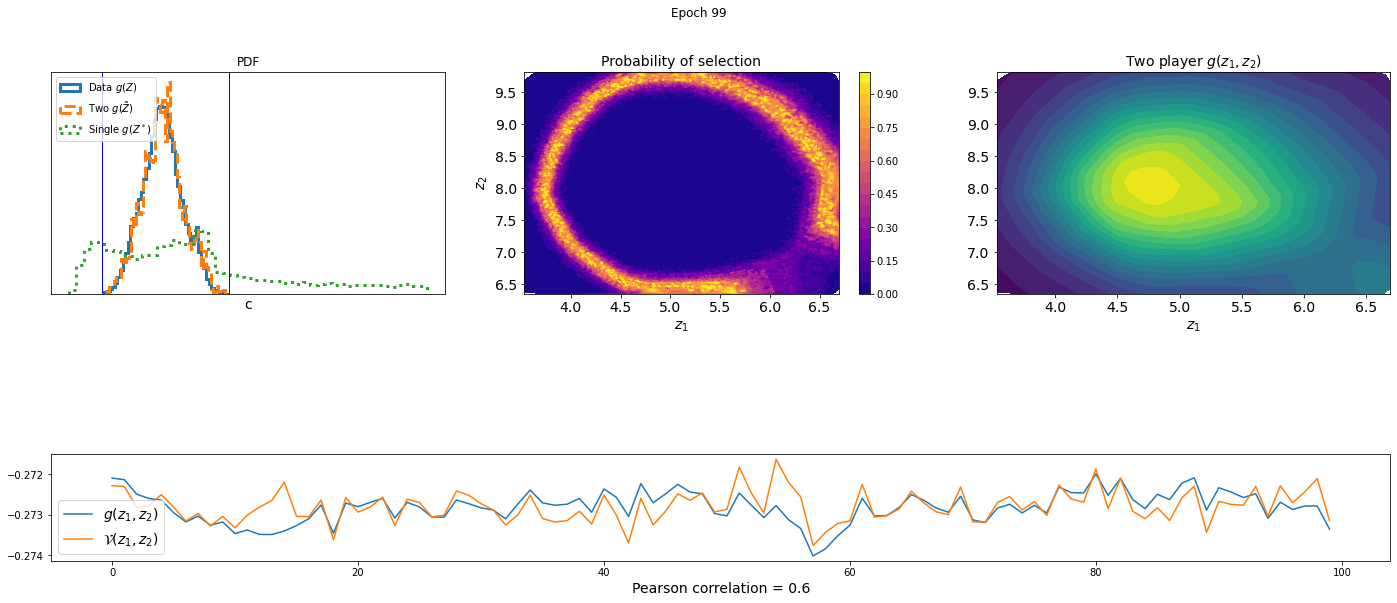

In [9]:
import torch.optim as optim
from IPython import display
import pandas as pd
%matplotlib inline

combinationPlayer = Combination_ANN(mu, Sigma_minus_half)
modelParams = combinationPlayer.parameters()
optimizer = optim.SGD(modelParams, lr=0.01, momentum=0.9, weight_decay=0.001)
nEpochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
combinationPlayer.to(device)

observations, Vtorch = observations.to(device), Vtorch.to(device)

print(f'Dataset contains {observations.shape[0]} systems, from each system a time-series of length {observations.shape[1]} is observed, each observation contains {observations.shape[2]} features')

for epoch in range(nEpochs):
  optimizer.zero_grad()
  # combination player:  
  combination, combinationOnNaiveShuffle, naiveShuffledObservations = combinationPlayer(observations)
  # shuffle player:
  combinationOnNaiveShuffle_selectionProb = shufflePlayer(combination, combinationOnNaiveShuffle)
  # Coefficient of Regulation:
  CR, CR_zeta1 = CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb)
  # update the combination player as to minimize the CR:
  CR.backward()
  optimizer.step()  # parameter update
  
  pearsonCorr = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(V.flatten()))

  #clear_output(wait=True)
  #print(f'Dataset contains {observations.shape[0]} systems, from each system a time-series of length {observations.shape[1]} is observed, each observation contains {observations.shape[2]} features')
  #print(f'epoch {epoch}: CR(zeta=1) = {CR_zeta1.item()}, CR = {CR.item()}') 
  #print(f'Pearson correlation between learned combination g() and ground-truth V = {pearsonCorr}')

  authenticData = pd.DataFrame(columns=['z1','z2','comb','combGT'], data=torch.cat((torch.reshape(observations[0:60], (-1,2)), torch.reshape(combination[0:60], (-1,1)), torch.reshape(Vtorch[0:60], (-1,1))), dim=1).detach().cpu().numpy())
  shuffledData = pd.DataFrame(columns=['z1','z2','comb','ProbAssignedByPlayer'], data=torch.cat((torch.reshape(naiveShuffledObservations[0:3,:10000], (-1,2)), torch.reshape(combinationOnNaiveShuffle[0:3,:10000], (-1,1)), torch.reshape(combinationOnNaiveShuffle_selectionProb[0:3,:10000], (-1,1))), dim=1).detach().cpu().numpy())
  printShufflePlayerAndCombination(authenticData, shuffledData, V.flatten().std(), V.flatten().mean(), epoch, pearsonCorr)

  
